# DSP experiments

This notebook contains DSP experiments to assess the accuracy of confidence level classification of climate statements by various LLMs.

In [1]:
try: 
    # This library is our indicator that the required installs
    # need to be done.
    import datasets
    root_path = '.'
except ModuleNotFoundError:
    !git clone https://github.com/cgpotts/cs224u/
    !pip install -r cs224u/requirements.txt
    root_path = 'dsp'

Cloning into 'cs224u'...
remote: Enumerating objects: 2223, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 2223 (delta 59), reused 89 (delta 49), pack-reused 2092
Receiving objects: 100% (2223/2223), 41.49 MiB | 27.01 MiB/s, done.
Resolving deltas: 100% (1358/1358), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/stanfordnlp/dsp to /tmp/pip-req-build-t6vr9ze0
  Running command git clone --filter=blob:none --quiet https://github.com/stanfordnlp/dsp /tmp/pip-req-build-t6vr9ze0
  Resolved https://github.com/stanfordnlp/dsp to commit 298fac8937fdf7326d1b85546ecd41f099ed33e2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 739.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 69.9 MB

Now we import modules to work with DSP, OpenAI, HuggingFace, and Cohere models

In [4]:
import pandas as pd 
import cohere
from datasets import load_dataset
import openai
import re
import os
import dsp
import transformers

Now we import key variables such as API keys. Steps:

1) Create a keys.txt file in the root of your /content/ folder in the Colab instance

2) Define the API keys you will use 

3) Run the cell below to import the file

In [378]:
# Read the contents of the file
with open('/content/keys.txt', 'r') as file:
    file_contents = file.read()

# Assign the variables
exec(file_contents)

os.environ["DSP_NOTEBOOK_CACHEDIR"] = os.path.join(root_path, 'cache')
openai_key = OPENAI_API_KEY  
cohere_key = COHERE_API_KEY  

## Model setting

Now we define a choice of LM and setup the DSP environment.

In [10]:
[d["root"] for d in openai.Model.list(api_key=openai_key)["data"]]

['whisper-1',
 'babbage',
 'davinci',
 'text-davinci-edit-001',
 'babbage-code-search-code',
 'text-similarity-babbage-001',
 'code-davinci-edit-001',
 'text-davinci-001',
 'ada',
 'babbage-code-search-text',
 'babbage-similarity',
 'gpt-3.5-turbo',
 'code-search-babbage-text-001',
 'text-curie-001',
 'code-search-babbage-code-001',
 'text-ada-001',
 'text-similarity-ada-001',
 'curie-instruct-beta',
 'ada-code-search-code',
 'ada-similarity',
 'code-search-ada-text-001',
 'text-search-ada-query-001',
 'davinci-search-document',
 'ada-code-search-text',
 'text-search-ada-doc-001',
 'davinci-instruct-beta',
 'text-similarity-curie-001',
 'code-search-ada-code-001',
 'ada-search-query',
 'text-search-davinci-query-001',
 'curie-search-query',
 'davinci-search-query',
 'babbage-search-document',
 'ada-search-document',
 'text-search-curie-query-001',
 'text-search-babbage-doc-001',
 'curie-search-document',
 'text-search-curie-doc-001',
 'babbage-search-query',
 'text-babbage-001',
 'text

In [381]:
## We use the chatGPT AR-LM model

#lm = dsp.GPT3(model = "gpt-4", api_key=openai_key, model_type="chat")
lm = dsp.Cohere(model = "command-xlarge-nightly", api_key=cohere_key)
dsp.settings.configure(lm=lm)
dsp.settings.show_guidelines = True

### Loading the dataset
Upload a tab separated version of the dataset to /content/.

In [48]:
dataset = pd.read_csv('ipcc_statements_dataset.tsv', sep='\t', skiprows=0)

train_set = df.loc[df['split'] == 'train']
test_set = df.loc[df['split'] == 'test']

test_set.tail

<bound method NDFrame.tail of       statement_idx     report  page_num  sent_num  \
3                 3    AR6_WGI        24         2   
42               42    AR6_WGI        37        16   
77               77    AR6_WGI        47         7   
81               81    AR6_WGI        62         2   
86               86    AR6_WGI        63         8   
...             ...        ...       ...       ...   
8024           8024  AR6_WGIII      1827        13   
8056           8056  AR6_WGIII      2011         5   
8067           8067  AR6_WGIII      2012         8   
8086           8086  AR6_WGIII      2016         8   
8093           8093  AR6_WGIII      2058        21   

                                              statement confidence  score  \
3     Since 1750, increases in CO2 (47%) and CH4 (15...  very high      3   
42    Over the next 2000 years, global mean sea leve...        low      0   
77    By the end of the century, scenarios with very...       high      2   
81    Over th

In [18]:
ipcc_sent = [dsp.Example(input=row['statement'], label=row['confidence'], score=row['score'], report=row['report'])
                    for _, row in test_set.iterrows()]

In [13]:
ipcc_sent[:10]

[{'input': 'Since 1750, increases in CO2 (47%) and CH4 (156%) concentrations far exceed – and increases in N2O (23%) are similar to – the natural multi-millennial changes between glacial and interglacial periods over at least the past 800,000 years',
  'label': 'very high'},
 {'input': 'Over the next 2000 years, global mean sea level will rise by about 2 to 3 m if warming is limited to 1.5°C, 2 to 6 m if limited to 2°C and 19 to 22 m with 5°C of warming, and it will continue to rise over subsequent millennia',
  'label': 'low'},
 {'input': 'By the end of the century, scenarios with very low and low GHG emissions would strongly limit the change of several CIDs, such as the increases in the frequency of extreme sea level events, heavy precipitation and pluvial flooding, and exceedance of dangerous heat thresholds, while limiting the number of regions where such exceedances occur, relative to higher GHG emissions scenarios',
  'label': 'high'},
 {'input': 'Over the past millennium, and es

### Perform checks on dataset


In [23]:
print(len(ipcc_sent))
print(len([ex for ex in ipcc_sent if ex.label=='low']))
print(len([ex for ex in ipcc_sent if ex.report=='AR6_WGIII']))
print(len([ex for ex in ipcc_sent if ex.score==2]))

300
50
35
100


## Defining templates

### Zero-shot learning
Testing how models do on the task right out of the gate.

In [330]:
Input = dsp.Type(
    prefix="Statement:", 
    desc="${a short statement about climate.}")

Label = dsp.Type(
    prefix="Confidence:", 
    desc="${must be *only*: 'low', 'medium', 'high', 'very high'}")

zero_shot_template = dsp.Template(
    instructions="You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change. \
      \n\nYou will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?  \
      \n\nRespond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.",
    input=Input(),
    output=Label())

Example:

In [331]:
ex = dsp.Example(
    input=ipcc_sent[0]['input'], label=ipcc_sent[0]['label'])

ex.demos=dsp.sample(ipcc_sent, 0)

print(zero_shot_template(ex))

You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.       

You will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?        

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.

---

Follow the following format.

Statement: ${a short statement about climate.}
Confidence: ${must be *only*: 'low', 'medium', 'high', 'very high'}

---

Statement: Since 1750, increases in CO2 (47%) and CH4 (156%) concentrations far exceed – and in

## Defining the task

With zero shot we simply provide instructions and provide a format template, with no training demonstrations.

In [332]:
@dsp.transformation
def assess_certainty(example, temperature=0.7): 
    
    example, completion = dsp.generate(zero_shot_template,  temperature=temperature)(example, stage='zero-shot')

    return completion

def extract_confidence(text):
    if re.search(r"low", text, re.IGNORECASE):
        return "low"
    elif re.search(r"medium", text, re.IGNORECASE):
        return "medium"
    elif re.search(r"very high", text, re.IGNORECASE):
        return "very high"
    elif re.search(r"high", text, re.IGNORECASE):
        return "high"
    elif re.search(r"i don't know", text, re.IGNORECASE):
        return "idk"
    else:
        return "N/A"

Testing our task on the first sentence of the dataset: gpt3.5-turbo gets this first task right!

In [370]:
assess_certainty(ex).label

'very high'

In [372]:
lm.inspect_history(n=1)





You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.       

You will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?        

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.

---

Follow the following format.

Statement: ${a short statement about climate.}
Confidence: ${must be *only*: 'low', 'medium', 'high', 'very high'}

---

Statement: Since 1750, increases in CO2 (47%) and CH4 (156%) concentrations far exceed – an

# First experiment

We assess the certainty level of the LM on the dataset, filter the output for extra "confidence" etc., then compare with ground truth.

In [382]:
samples = test_set.copy()  # Dev: train_set.sample(n=100, random_state=12).copy() | Experiment: test_set.copy()

samples.head

<bound method NDFrame.head of       statement_idx     report  page_num  sent_num  \
3                 3    AR6_WGI        24         2   
42               42    AR6_WGI        37        16   
77               77    AR6_WGI        47         7   
81               81    AR6_WGI        62         2   
86               86    AR6_WGI        63         8   
...             ...        ...       ...       ...   
8024           8024  AR6_WGIII      1827        13   
8056           8056  AR6_WGIII      2011         5   
8067           8067  AR6_WGIII      2012         8   
8086           8086  AR6_WGIII      2016         8   
8093           8093  AR6_WGIII      2058        21   

                                              statement confidence  score  \
3     Since 1750, increases in CO2 (47%) and CH4 (15...  very high      3   
42    Over the next 2000 years, global mean sea leve...        low      0   
77    By the end of the century, scenarios with very...       high      2   
81    Over th

In [383]:
samples['prediction'] = samples.statement.apply(
    lambda x: extract_confidence(assess_certainty(dsp.Example(input=x, demos=dsp.sample(ipcc_sent, 0)), temperature=0).output.lower()))

In [357]:
lm.inspect_history(n=1)





You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.       

You will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?        

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.

---

Follow the following format.

Statement: ${a short statement about climate.}
Confidence: ${must be *only*: 'low', 'medium', 'high', 'very high'}

---

Statement: Ocean warming is irreversible over centuries to millennia, but the magnitude of 

In [385]:
samples['correct'] = samples.apply(
    lambda row: (row['confidence'] == row['prediction']), axis=1)

print(f"Accuracy: {samples['correct'].sum() / (samples.shape[0]-len(samples[samples['prediction'] == 'idk'])):.3f}")
print(f"'I don't know': {len(samples[samples['prediction'] == 'idk'])}")
print(f"N/A: {len(samples[samples['prediction'] == 'N/A'])}")

Accuracy: 0.310
'I don't know': 0
N/A: 0


In [308]:
samples.loc[samples['confidence'] == 'very high'].head

<bound method NDFrame.head of       statement_idx     report  page_num  sent_num  \
3                 3    AR6_WGI        24         2   
190             190    AR6_WGI        93        13   
497             497    AR6_WGI       203        15   
741             741    AR6_WGI       463        12   
855             855    AR6_WGI       593         3   
922             922    AR6_WGI       692         7   
1390           1390    AR6_WGI      1230        13   
1591           1591    AR6_WGI      1382        27   
2016           2016    AR6_WGI      1864        23   
2095           2095    AR6_WGI      1876        18   
2310           2310   AR6_WGII        20        16   
2392           2392   AR6_WGII        26         4   
2430           2430   AR6_WGII        31        15   
2473           2473   AR6_WGII        36        18   
2572           2572   AR6_WGII        58         9   
2589           2589   AR6_WGII        59        15   
2930           2930   AR6_WGII        95         6  

## Saving experiment results

Make sure to save the results for future analysis if needed.

In [363]:
samples.to_csv('gpt4-zeroshot-temp0-202306090044.csv', index=False)

## Precision, recall, and F1 score

In [386]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

true_labels = samples.loc[samples['prediction'] != 'idk', 'confidence']
predicted_labels = samples.loc[samples['prediction'] != 'idk', 'prediction']

# Compute macro F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro')
print("Macro F1 score:", f1)

# Compute weighted F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("Weighted F1 score:", f1)

# Compute precision for each class
precision = precision_score(true_labels, predicted_labels, average=None)

# Compute recall for each class
recall = recall_score(true_labels, predicted_labels, average=None)

# Compute F1 score for each class
f1 = f1_score(true_labels, predicted_labels, average=None)

# Create a dataframe to store precision and recall for each class
class_metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1': f1})

# Add labels to the class metrics dataframe
class_metrics_df['Class'] = true_labels.unique().astype(str)

# Sort the dataframe by class index or name
class_metrics_df = class_metrics_df.sort_values('Class', key=lambda x: pd.Categorical(x, categories=["low", "medium", "high", "very high"]))

# Print class metrics dataframe
#print(class_metrics_df)

# Compute accuracy for the whole system
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute accuracy by class

print("Accuracy (total):", accuracy)

report = classification_report(true_labels, predicted_labels, digits=4)
print(report)

# Count classes
category_counts = true_labels.value_counts()
print(category_counts)



Macro F1 score: 0.1937667241436784
Weighted F1 score: 0.20944680312322064
Accuracy (total): 0.31
              precision    recall  f1-score   support

        high     0.3319    0.7600    0.4620       100
         low     1.0000    0.0200    0.0392        50
      medium     0.5000    0.0100    0.0196       100
   very high     0.2206    0.3000    0.2542        50

    accuracy                         0.3100       300
   macro avg     0.5131    0.2725    0.1938       300
weighted avg     0.4807    0.3100    0.2094       300

high         100
medium       100
very high     50
low           50
Name: confidence, dtype: int64


## Over/under confidence assessment

In [387]:
filtered_samples = samples.loc[(samples['prediction'] != 'N/A')] # & (samples['report'] != 'AR6_WGI')]

value_map = {'low': 0, 'medium': 1, 'high': 2, 'very high': 3, 'idk': 1.5}

filtered_samples['predicted_score'] = filtered_samples.prediction.apply(
    lambda x: value_map[x])

scores_all = {
    "low": filtered_samples.loc[samples['score'] == 0, 'predicted_score'].mean(),
    "medium": filtered_samples.loc[samples['score'] == 1, 'predicted_score'].mean(),
    "high": filtered_samples.loc[samples['score'] == 2, 'predicted_score'].mean(),
    "very high": filtered_samples.loc[samples['score'] == 3, 'predicted_score'].mean()
}

scores_wg1 = {
    "low": filtered_samples.loc[(samples['score'] == 0) & (samples['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "medium": filtered_samples.loc[(samples['score'] == 1) & (samples['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "high": filtered_samples.loc[(samples['score'] == 2) & (samples['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "very high": filtered_samples.loc[(samples['score'] == 3) & (samples['report'] == 'AR6_WGI'), 'predicted_score'].mean()
}

scores_wg23 = {
    "low": filtered_samples.loc[(samples['score'] == 0) & (samples['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "medium": filtered_samples.loc[(samples['score'] == 1) & (samples['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "high": filtered_samples.loc[(samples['score'] == 2) & (samples['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "very high": filtered_samples.loc[(samples['score'] == 3) & (samples['report'] != 'AR6_WGI'), 'predicted_score'].mean()
}

print("=== All AR6 reports===")
print(f"Average ground truth score: {filtered_samples['score'].mean()}")
print(f"Average predicted score: {filtered_samples['predicted_score'].mean()}")
print(f"Average scores per category: {scores_all}\n")

print("=== AR6 WGI report ===")
print(f"Average ground truth score: {filtered_samples.loc[filtered_samples['report'] == 'AR6_WGI', 'score'].mean()}")
print(f"Average predicted score: {filtered_samples.loc[filtered_samples['report'] == 'AR6_WGI', 'predicted_score'].mean()}")
print(f"Average scores per category: {scores_wg1}\n")

print("=== AR6 WGII/III reports ===")
print(f"Average ground truth score: {filtered_samples.loc[filtered_samples['report'] != 'AR6_WGI', 'score'].mean()}")
print(f"Average predicted score: {filtered_samples.loc[filtered_samples['report'] != 'AR6_WGI', 'predicted_score'].mean()}")
print(f"Average scores per category: {scores_wg23}\n")

=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 2.2133333333333334
Average scores per category: {'low': 2.08, 'medium': 2.21, 'high': 2.24, 'very high': 2.3}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 2.2842105263157895
Average scores per category: {'low': 2.15, 'medium': 2.257142857142857, 'high': 2.3, 'very high': 2.6}

=== AR6 WGII/III reports ===
Average ground truth score: 1.5853658536585367
Average predicted score: 2.180487804878049
Average scores per category: {'low': 2.033333333333333, 'medium': 2.1846153846153844, 'high': 2.2142857142857144, 'very high': 2.225}



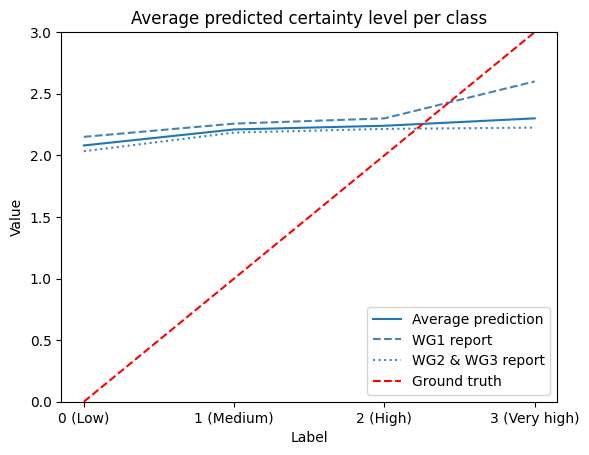

In [388]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the data

# Extract labels and values from the data dictionary
labels = list(scores_all.keys())
values_all = list(scores_all.values())
values_wg1 = list(scores_wg1.values())
values_wg23 = list(scores_wg23.values())

# Define the custom labels for the x-axis
x_labels = ['0 (Low)', '1 (Medium)', '2 (High)', '3 (Very high)']

# Create the line plot with labeled curve
sns.lineplot(x=labels, y=values_all, label='Average prediction')
sns.lineplot(x=labels, y=values_wg1, linestyle='--', color="steelblue", label='WG1 report')
sns.lineplot(x=labels, y=values_wg23, linestyle='dotted', color="steelblue", label='WG2 & WG3 report')


# Add the ground truth line (y = x)
x = np.arange(len(labels))
plt.plot(x, x, linestyle='--', color='red', label='Ground truth')

# Customize the x-axis tick labels
plt.xticks(labels, x_labels)

# Set the y-axis limits
plt.ylim(0, 3)

# Set the title and labels
plt.title("Average predicted certainty level per class")
plt.xlabel("Label")
plt.ylabel("Value")

# Show the legend
plt.legend()

# Show the plot
plt.show()